# APPM 4650
# Soroush Khadem

In [2]:
import numpy as np
from scipy.special import roots_laguerre
from scipy.linalg import hilbert
from scipy.integrate import quad
import matplotlib.pyplot as plt
from timeit import timeit
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

# Problem 1

## 1a

In [3]:
# Because Gauss-Laguerre divides by e^x, make sure to multiply it back into the function
f = lambda x : (1/(1+x**2))*np.exp(x)
F = lambda x : np.arctan(x)

In [4]:
a = 0
b = np.inf
I = F(b) - F(a)
I *= 2

/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:192: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:198: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:192: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


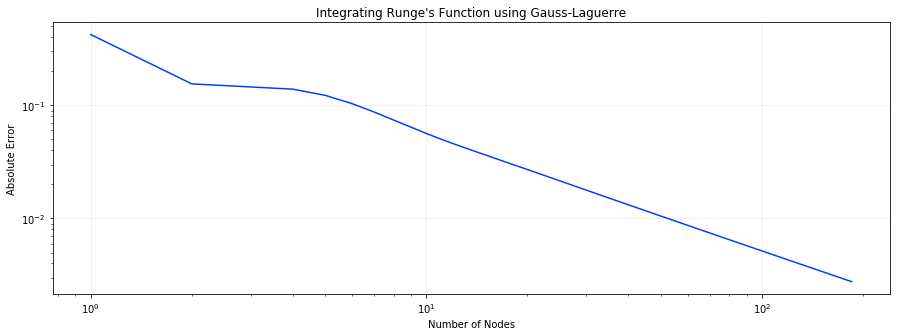

In [5]:
ns = np.arange(1, 200)
errors = []
for n in ns:
    x, w = roots_laguerre(n)
    errors.append(np.abs(I - 2*np.sum(f(x)*w)))
plt.plot(ns, errors)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Absolute Error')
plt.xlabel('Number of Nodes')
plt.title('Integrating Runge\'s Function using Gauss-Laguerre')
plt.show()

In [262]:
errors = np.array(errors)
last_index = np.where(np.isnan(errors) == False)[-1][-1] - 1
print('For n = %s, error is %s'%(last_index, errors[last_index]))

For n = 184, error is 0.0027617962438091226


The smallest error occurs at 184 nodes, and is 0.00276. This is because with more nodes than 184 nodes, overflow occurs, and the Gauss-Laguerre method goes to infinity. Therefore, no it is not possible to get arbitrarily close to machine precision

## 1b

Plugging in $x = e^t -1$, the result is:

$\int_0^\infty \frac{1}{1 + x^2}dx = \int_0^\infty \frac{1}{1 + (e^t - 1)^2} e^t dt = \int_0^\infty \frac{e^t}{e^{2t} - 2e^t +2} dt$

Because we are using Gauss-Laguerre, multiply by $e^t$ to offset the extra term:

$\int_0^\infty \frac{e^{2t}}{e^{2t} - 2e^t +2} dt$

However, because there are positive exponentials, this function can easily blow up. Thus, simplify by multiplying top and bottom by $e^{-2t}$:

$\int_0^\infty \frac{1}{1 - 2e^{-t} + 2e^{-2t}} dt$

In [6]:
f_changed = lambda t : (1) / (1 - 2*np.exp(-t) + 2*np.exp(-2*t))

/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:192: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:198: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
/Users/soroushkhadem/anaconda3/lib/python3.6/site-packages/scipy/special/orthogonal.py:192: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)


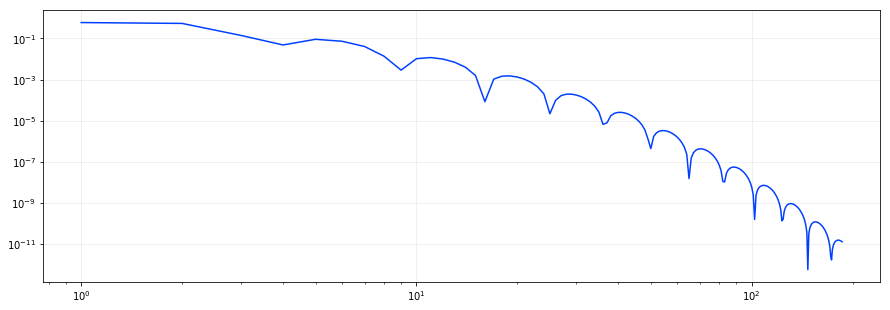

In [7]:
ns = np.arange(1, 200)
errors = []
for n in ns:
    x, w = roots_laguerre(n)
    errors.append(np.abs(I - 2*np.sum(f_changed(x)*w)))

plt.plot(ns, errors)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [8]:
errors = np.array(errors)
last_index = np.where(np.isnan(errors) == False)[-1][-1] - 1
print('For n = %s, error is %s'%(last_index, errors[last_index]))

For n = 184, error is 1.3419487743249192e-11


Once again, there is overflow preventing the error from completely diverging, but this time, using 184 nodees results in an error of 1e-11, much better than before. This is because we are essentially "condensing" the x-axis, causing much more of the area under the curve to be covered by using the same nodes

## Problem 2

## 2a

In [217]:
def baseQuadratureRule(f, a, b):
  """1D integration of f(x) from a to b"""

  Q, _ = quad(f,a,b,epsabs=1.5e-8,epsrel=1.5e-8,limit=50)
  return Q

In [237]:
def quad2D(f, bounds, baseQuadRule):
    """Integrates a 2D function from bounds[0] to bounds[1]
    and from bounds[2] to bounds[3], using `baseQuadRule`"""
    assert len(bounds) == 4
    @np.vectorize
    def a(x):
        def b(y):
            return f(np.array([x,y]))
        return baseQuadRule(b, bounds[2], bounds[3])
    return baseQuadRule(a, bounds[0], bounds[1])

def quad3D(f, bounds, baseQuadRule):
    """Integrates a 3D function from bounds[0] to bounds[1]
    and from bounds[2] to bounds[3], etc, using `baseQuadRule`"""
    assert len(bounds) == 6
    # Note: this is added to speed up problem 2, should be removed for the general case
    hilbert_mat = hilbert(3)
    @np.vectorize
    def a(x):
        def b(y):
            def c(z):
                # See note above
                return f(np.array([x,y,z]), hilbert_mat)
            return baseQuadRule(c, bounds[4], bounds[5])
        return baseQuadRule(b, bounds[2], bounds[3])
    return baseQuadRule(a, bounds[0], bounds[1])

def quad4D(f, bounds, baseQuadRule):
    """Integrates a 4D function from bounds[0] to bounds[1]
    and from bounds[2] to bounds[3], etc, using `baseQuadRule`"""
    assert len(bounds) == 8
    # Note: this is added to speed up problem 2, should be removed for the general case
    hilbert_mat = hilbert(4)
    @np.vectorize
    def a(x):
        def b(y):
            def c(z):
                def d(w):
                    # See note above
                    return f(np.array([x,y,z,w]), hilbert_mat)
                return baseQuadRule(d, bounds[6], bounds[7])
            return baseQuadRule(c, bounds[4], bounds[5])
        return baseQuadRule(b, bounds[2], bounds[3])
    return baseQuadRule(a, bounds[0], bounds[1])

def quad_high_dim(f, bounds, baseQuadRule):
    """
    Integrates f, for the dimensions specified in `bounds`
    Note: only implemented for dimensions 1, 2, 3, and 4
    :@param f: The function to integrate. Function is expected 
        to take in an np.array, representing a high dimensional variable 
    :@param bounds: Array of bounds, in pairs. 
        Ex. for 2D, bounds should be [a, b, c, d], which means x 
        will be integrated from a to b, and y will be integrated from c to d
    :@param baseQuadRule: The base quadrature rule to use
    """
    if len(bounds) == 2:
        return baseQuadRule(f, bounds[0], bounds[1])
    elif len(bounds) == 4:
        return quad2D(f, bounds, baseQuadRule)
    elif len(bounds) == 6:
        return quad3D(f, bounds, baseQuadRule)
    elif len(bounds) == 8:
        return quad4D(f, bounds, baseQuadRule)
    else:
        raise NotImplementedError

## 2b

In [268]:
def f(x, hilbert_mat=None):
    """
    Allows for a cached Hilbert\ matrix to be passed in, for perfomance reasons. 
    If not passed in, constructed at runtime
    """
    if np.isscalar(x):
        x = np.array([x])
    if hilbert_mat is None:
        hilbert_mat = hilbert(len(x))
    return x.T.dot(hilbert_mat).dot(x)

In [269]:
def p(x_vec):
    if np.isscalar(x_vec):
        dim = 1
    else:
        dim = len(x_vec)
    return (1/(2*np.pi)**(dim/2)) * np.exp(np.sum(-(x_vec**2)/2))

In [226]:
# Expectation value
def g(x, hilbert_mat=None):
    return f(x, hilbert_mat) * p(x)

For a 1D (scalar), expect to get 1

In [229]:
quad_high_dim(g, [-5, 5], baseQuadratureRule)

0.999984559501709

For 2D, expect to get 1.33333...

In [230]:
quad_high_dim(g, [-5, 5, -5, 5], baseQuadratureRule)

1.3333119816098895

For 3D, expect to get 1.53333...

In [235]:
quad_high_dim(g, [-5, 5, -5, 5, -5, 5], baseQuadratureRule)

1.533307899800628

Seems like the code is working as expected. Thus, move on to 4D. Note that this is SLOW

## 2bi

In [238]:
quad_high_dim(g, [-5, 5, -5, 5, -5, 5, -5, 5], baseQuadratureRule)

1.6761617121244665

## 2bii

For the base quadrature, I used an absolute episilon and relative epsilon equal to 1.5e-8, about the default values. I also set the mac number of subintervals to be 50. Below are the results of timing the function.

In [270]:
%time quad_high_dim(g, [-5, 5], baseQuadratureRule)

CPU times: user 7.59 ms, sys: 11 ms, total: 18.6 ms
Wall time: 28 ms


0.999984559501709

For 1D, the function completes in 28ms, not bad.

In [271]:
%time quad_high_dim(g, [-5, 5, -5, 5], baseQuadratureRule)

CPU times: user 731 ms, sys: 38 ms, total: 769 ms
Wall time: 988 ms


1.3333119816098895

For 2D, the function completes in 988ms, still not bad, but we can see it is starting to grow fast...

In [272]:
%time quad_high_dim(g, [-5, 5, -5, 5, -5, 5], baseQuadratureRule)

CPU times: user 10.8 s, sys: 322 ms, total: 11.1 s
Wall time: 11.7 s


1.533307899800628

For 3D, now it's getting pretty long, at 11.7 seconds.

In [273]:
%time quad_high_dim(g, [-5, 5, -5, 5, -5, 5, -5, 5], baseQuadratureRule)

CPU times: user 7min 58s, sys: 8.57 s, total: 8min 7s
Wall time: 9min 11s


1.6761617121244665

With 4D, the code becomes nearly unusable since it takes 9 minutes!

## 2c

In [125]:
def four_estimate():
    hilbert_mat = hilbert(4)
    tot = np.zeros(int(1e6))
    for i in range(len(tot)): 
        tot[i] = f(np.random.randn(4), hilbert_mat)
    return np.mean(tot)

In [239]:
%time expectation_4 = four_estimate()
print(np.abs(1.6761617121244665 - expectation_4))

CPU times: user 6.78 s, sys: 132 ms, total: 6.91 s
Wall time: 8.67 s
0.00010793277732012996


With only 8.67 seconds of runtime, can get the same answer with 1e-4 accuracy. Monte Carlo to the rescue!

In [111]:
def twelve_estimate():
    hilbert_mat = hilbert(12)
    tot = np.zeros(int(1e6))
    for i in range(len(tot)): 
        tot[i] = f(np.random.randn(12), hilbert_mat)
    return np.mean(tot)

In [112]:
%time expectation_12 = twelve_estimate()
print(np.abs(2.224352838648 - expectation_12))

CPU times: user 3.05 s, sys: 38.1 ms, total: 3.09 s
Wall time: 3.3 s
6.972654658188304e-05


In [113]:
def hundred_estimate():
    hilbert_mat = hilbert(100)
    tot = np.zeros(int(1e6))
    for i in range(len(tot)): 
        tot[i] = f(np.random.randn(100), hilbert_mat)
    return np.mean(tot)

In [114]:
%time expectation_100 = hundred_estimate()
print(np.abs(3.284342189302 - expectation_100))

CPU times: user 18.9 s, sys: 2.07 s, total: 21 s
Wall time: 12.8 s
0.0059789750588450374


The Monte Carlo method sacrifices some accuracy for a much, much faster runtime. For a dimension such as 100, it is simply infeasible to run the quadrature method due to the incredibly slow performance. Plus, with better hardware, a higher number of iterations can be run, and the accuracy would increase.